In [1]:
from __future__ import annotations
import json
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional

# === Utils ===
def _rng(seed: Optional[int]) -> np.random.Generator:
    return np.random.default_rng(None if seed is None else int(seed))

def sample_positions_in_disk(n: int, radius: float = 1.0, center: Tuple[float, float] = (0.0, 0.0),
                             seed: Optional[int] = None) -> np.ndarray:
    """Uniformly sample n points in a disk."""
    rng = _rng(seed)
    angles = rng.uniform(0.0, 2.0*np.pi, size=n)
    radii  = np.sqrt(rng.uniform(0.0, 1.0, size=n)) * radius
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return np.stack([x, y], axis=1)

def rotate_points(xy: np.ndarray, angle_rad: float) -> np.ndarray:
    """Rotate 2D points CCW by angle_rad."""
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    R = np.array([[c, -s],[s, c]], dtype=xy.dtype)
    return xy @ R.T

def assign_types_half_disk(xy: np.ndarray, boundary_angle_rad: float = 0.0,
                           cross_boundary_band: float = 0.0, band_flip_prob: float = 0.0,
                           global_flip_frac: float = 0.0, seed: Optional[int] = None) -> np.ndarray:
    """
    Two types by a rotated diameter split.
    - boundary_angle_rad: rotate split line
    - cross_boundary_band: band half-width around boundary (|x_rot| <= band)
    - band_flip_prob: flip prob within band
    - global_flip_frac: random flips anywhere
    """
    rng = _rng(seed)
    xy_rot = rotate_points(xy, -boundary_angle_rad)
    x_rot  = xy_rot[:, 0]
    labels = (x_rot >= 0).astype(np.int64)   # right=1, left=0

    if cross_boundary_band > 0.0 and band_flip_prob > 0.0:
        in_band   = np.abs(x_rot) <= cross_boundary_band
        flip_mask = in_band & (rng.uniform(0,1,size=xy.shape[0]) < band_flip_prob)
        labels[flip_mask] = 1 - labels[flip_mask]

    if global_flip_frac > 0.0:
        n = xy.shape[0]
        k = int(round(global_flip_frac * n))
        if k > 0:
            idx = rng.choice(n, size=k, replace=False)
            labels[idx] = 1 - labels[idx]
    return labels

# === Time series helpers ===
def ar1_noise(T: int, phi: float, sigma: float, rng: np.random.Generator) -> np.ndarray:
    """AR(1): x_t = phi * x_{t-1} + eps_t."""
    x = np.empty(T, dtype=np.float32)
    x[0] = rng.normal(0.0, sigma)
    for t in range(1, T):
        x[t] = phi * x[t-1] + rng.normal(0.0, sigma)
    return x

def zscore(a: np.ndarray, axis: Optional[int] = None, eps: float = 1e-8) -> np.ndarray:
    m = np.mean(a, axis=axis, keepdims=True)
    s = np.std(a, axis=axis, keepdims=True)
    return (a - m) / (s + eps)

def default_type_waveforms(T: int, baseline_frac: float = 0.8, amp: float = 1.0,
                           rng: Optional[np.random.Generator] = None):
    if rng is None:
        rng = _rng(None)

    T_b = int(round(baseline_frac * T))
    u   = np.zeros(T, dtype=np.float32)
    window = max(8, T - T_b)
    t   = np.arange(window, dtype=np.float32)
    bump  = np.sin(np.pi * (t / window))
    decay = np.exp(-t / max(4.0, window/6.0)).astype(np.float32)
    w     = bump * decay
    w     = w / (np.max(np.abs(w)) + 1e-8) * amp
    u[T_b:T_b+window] = w[:max(0, min(window, T - T_b))]

    jitter = ar1_noise(T, phi=0.9, sigma=0.05, rng=rng)
    u_shared = zscore(u + 0.5*jitter).astype(np.float32)

    dA = zscore(ar1_noise(T, phi=0.95, sigma=0.05, rng=rng)).astype(np.float32)
    dB = np.roll(u_shared, shift=1)
    dB = zscore(dB).astype(np.float32)

    rho = 0.9
    scale = np.sqrt(max(1.0 - rho**2, 1e-6))

    uA = zscore(rho * u_shared + scale * dA).astype(np.float32)
    uB = zscore(rho * u_shared + scale * dB).astype(np.float32)
    return uA, uB
def calcium_kernel(T: int, dt: float, tau: float) -> np.ndarray:
    """Exponential calcium kernel (length T)."""
    t = np.arange(T, dtype=np.float32)
    return np.exp(-t * dt / max(tau, 1e-3)).astype(np.float32)

def causal_convolve(signal: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Causal 1D convolution: keep same length as input."""
    T = signal.shape[-1]
    full = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode="full")[:T], -1, signal)
    return full

# === Config & generator ===
@dataclass
class SimulatorConfig:
    n_neurons: int = 500
    n_trials:  int = 12
    T: int = 300
    dt: float = 1/8   # 8 Hz

    # Spatial
    radius: float = 1.0
    center_x: float = 0.0
    center_y: float = 0.0
    boundary_angle_rad: float = 0.0
    cross_boundary_band: float = 0.05
    band_flip_prob: float = 0.5
    global_flip_frac: float = 0.0

    # Correlation control
    target_within_type_corr: float = 0.2
    alpha_std: float = 0.10

    # Waveform & noise
    baseline_frac: float = 0.8
    amp: float = 1.0
    neuron_noise_phi: float = 0.6
    trial_noise_phi: float = 0.4
    neuron_noise_std: float = 1.0
    trial_noise_std: float = 0.3
    meas_noise_std:  float = 0.05

    # Calcium
    tau_decay: float = 0.8
    apply_calcium: bool = True

    add_artifact: bool = False
    artifact_rect: Tuple[float, float, float, float] = (-1.0, -1.0, -0.2, 1.0)  # xmin,ymin,xmax,ymax
    artifact_scale: float = 0.8

    # Seed
    seed: Optional[int] = 42

def generate_dataset(cfg: SimulatorConfig) -> Dict[str, np.ndarray]:
    """Generate spatial multi-trial dataset."""
    rng = _rng(cfg.seed)

    # Positions & labels
    positions = sample_positions_in_disk(
        cfg.n_neurons, radius=cfg.radius,
        center=(cfg.center_x, cfg.center_y), seed=rng.integers(1<<31)
    )
    labels = assign_types_half_disk(
        positions,
        boundary_angle_rad=cfg.boundary_angle_rad,
        cross_boundary_band=cfg.cross_boundary_band,
        band_flip_prob=cfg.band_flip_prob,
        global_flip_frac=cfg.global_flip_frac,
        seed=rng.integers(1<<31),
    )

    # Shared waveforms
    uA, uB = default_type_waveforms(
        cfg.T, baseline_frac=cfg.baseline_frac, amp=cfg.amp, rng=rng
    )

    # Alphas ~ control within-type correlation ≈ target
    mu_alpha = float(np.sqrt(max(cfg.target_within_type_corr, 1e-6)))
    alphas = np.clip(
        rng.normal(loc=mu_alpha, scale=cfg.alpha_std, size=cfg.n_neurons), 0.0, 1.0
    ).astype(np.float32)

    # Neuron-specific AR(1) eps (z-scored)
    eps = np.stack([
        zscore(ar1_noise(cfg.T, cfg.neuron_noise_phi, cfg.neuron_noise_std, rng))
        for _ in range(cfg.n_neurons)
    ], axis=0).astype(np.float32)

    # Base (per neuron) before trials
    base = np.empty((cfg.n_neurons, cfg.T), dtype=np.float32)
    for i in range(cfg.n_neurons):
        u  = uA if labels[i] == 0 else uB
        ai = alphas[i]
        base[i] = ai * u + np.sqrt(max(1.0 - ai*ai, 0.0)) * eps[i]
    base = zscore(base, axis=1).astype(np.float32)

    # Calcium kernel
    k = calcium_kernel(cfg.T, cfg.dt, cfg.tau_decay) if cfg.apply_calcium else np.array([1.0], dtype=np.float32)

    # Trials
    traces = np.empty((cfg.n_neurons, cfg.n_trials, cfg.T), dtype=np.float32)
    for l in range(cfg.n_trials):
        trial_eps    = np.stack([
            ar1_noise(cfg.T, cfg.trial_noise_phi, cfg.trial_noise_std, rng)
            for _ in range(cfg.n_neurons)
        ], axis=0).astype(np.float32)
        trial_signal = base + trial_eps

        if cfg.add_artifact:
            xmin, ymin, xmax, ymax = cfg.artifact_rect
            in_rect = (positions[:,0]>=xmin) & (positions[:,0]<=xmax) & (positions[:,1]>=ymin) & (positions[:,1]<=ymax)
            stim = np.abs(uA)[None, :]
            trial_signal[in_rect] = trial_signal[in_rect] + cfg.artifact_scale * stim

        convolved = causal_convolve(trial_signal, k)
        meas      = _rng(rng.integers(1<<31)).normal(0.0, cfg.meas_noise_std, size=convolved.shape).astype(np.float32)
        traces[:, l, :] = convolved + meas

    params = asdict(cfg)
    return dict(
        positions=positions.astype(np.float32),
        labels=labels.astype(np.int64),
        traces=traces.astype(np.float32),
        uA=uA.astype(np.float32),
        uB=uB.astype(np.float32),
        alphas=alphas.astype(np.float32),
        params=params
    )

def estimate_pairwise_corr_summary(traces: np.ndarray, labels: np.ndarray,
                                   n_pairs: int = 5000, seed: Optional[int] = 0) -> Dict[str, float]:
    rng = _rng(seed)
    x = traces.mean(axis=1)       # (N, T)
    x = zscore(x, axis=1)

    def sample_pairs(idx: np.ndarray) -> float:
        if len(idx) < 2:
            return float("nan")
        m = len(idx)
        n = min(n_pairs, m*(m-1)//2)
        vals = []
        for _ in range(n):
            i, j = rng.choice(idx, size=2, replace=False)
            vals.append(np.corrcoef(x[i], x[j])[0,1])
        return float(np.mean(vals)) if vals else float("nan")

    idx0 = np.where(labels == 0)[0]
    idx1 = np.where(labels == 1)[0]
    within0 = sample_pairs(idx0)
    within1 = sample_pairs(idx1)

    def sample_between(i0: np.ndarray, i1: np.ndarray) -> float:
        if len(i0)==0 or len(i1)==0:
            return float("nan")
        n = min(n_pairs, len(i0)*len(i1))
        vals = []
        for _ in range(n):
            i = rng.choice(i0)
            j = rng.choice(i1)
            vals.append(np.corrcoef(x[i], x[j])[0,1])
        return float(np.mean(vals)) if vals else float("nan")

    between = sample_between(idx0, idx1)
    return {
        "within_type0_mean_corr": within0,
        "within_type1_mean_corr": within1,
        "between_types_mean_corr": between
    }

print("Simulator ready.")

Simulator ready.


In [3]:
cfg = SimulatorConfig(
    n_neurons=1000,
    n_trials=12,
    T=1000,
    boundary_angle_rad=0.0,
    cross_boundary_band=0.05,
    band_flip_prob=0.3,
    global_flip_frac=0.02,
    target_within_type_corr=0.05,
    alpha_std=0.10,
    add_artifact=False,
    seed=123
)

data = generate_dataset(cfg)
positions = data["positions"]
labels    = data["labels"]
traces    = data["traces"]       # (N, n_trials, T)
uA, uB    = data["uA"], data["uB"]
print("shapes -> positions:", positions.shape, "| labels:", labels.shape, "| traces:", traces.shape)

shapes -> positions: (1000, 2) | labels: (1000,) | traces: (1000, 12, 1000)


In [4]:
summary = estimate_pairwise_corr_summary(traces, labels, n_pairs=4000, seed=0)
print(json.dumps(summary, indent=2))

{
  "within_type0_mean_corr": 0.16576560251486727,
  "within_type1_mean_corr": 0.1481305995360816,
  "between_types_mean_corr": 0.14015936233219822
}


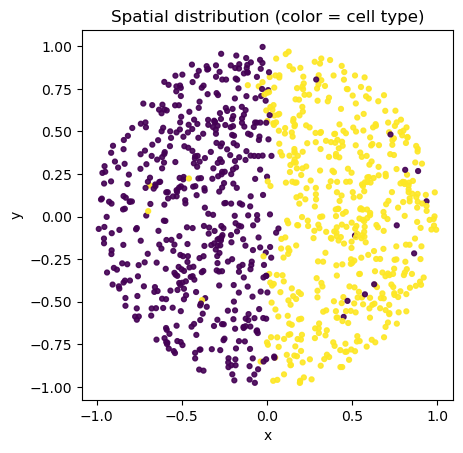

In [5]:
plt.figure()
plt.scatter(positions[:,0], positions[:,1], c=labels, s=12, alpha=0.9)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Spatial distribution (color = cell type)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

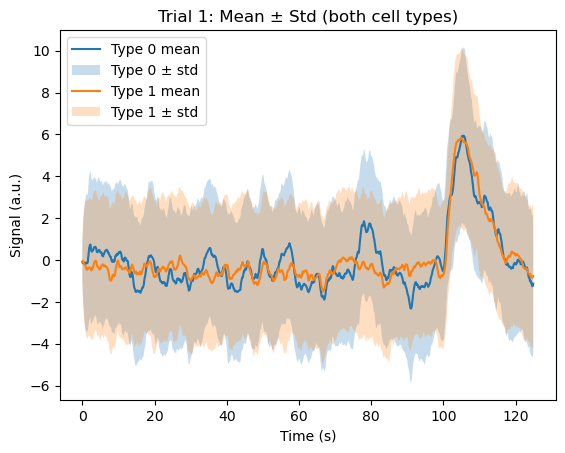

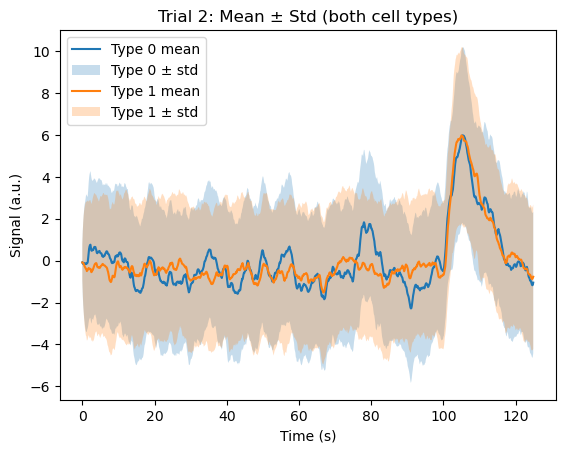

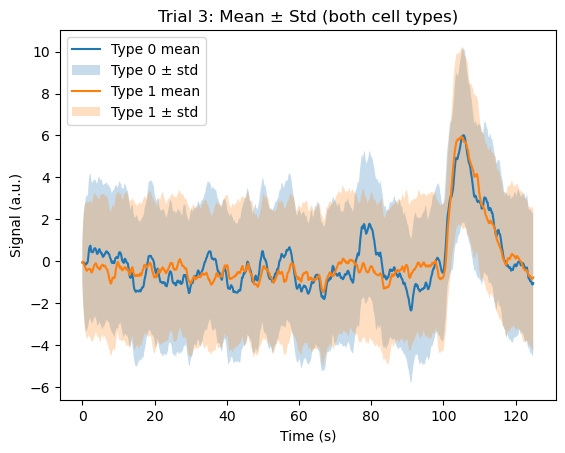

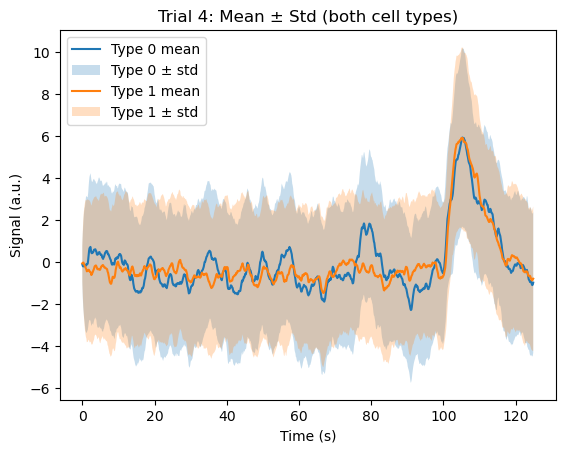

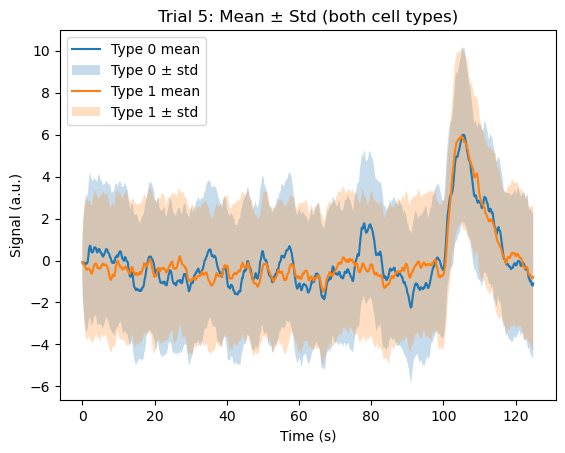

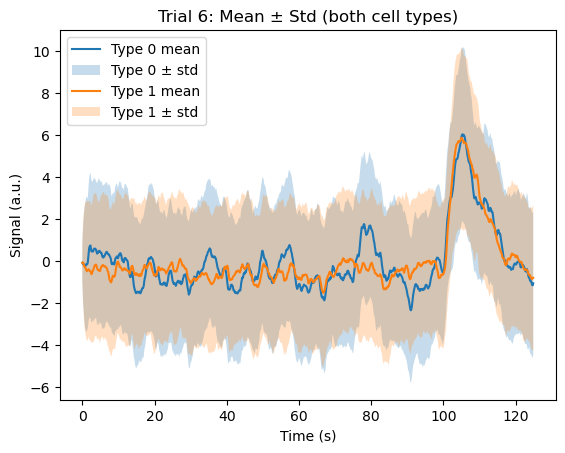

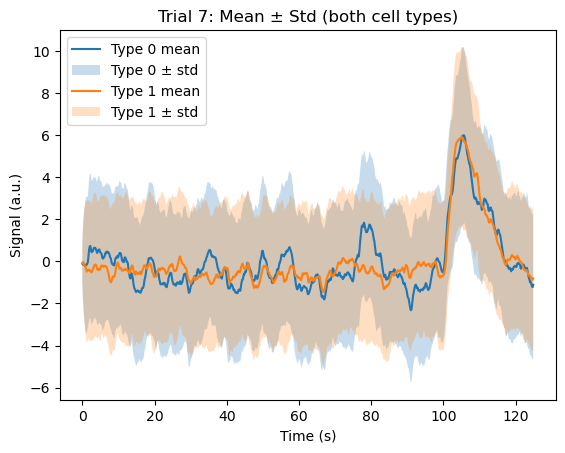

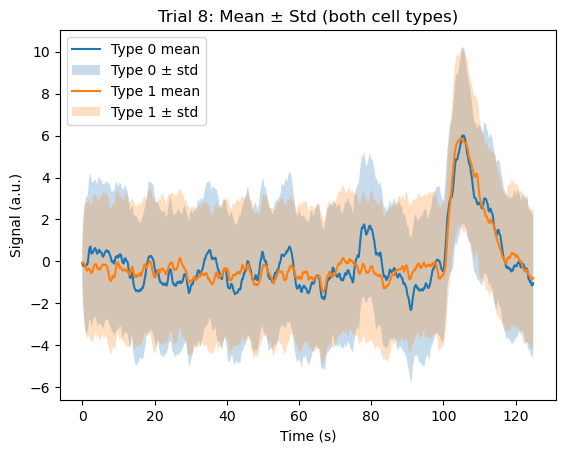

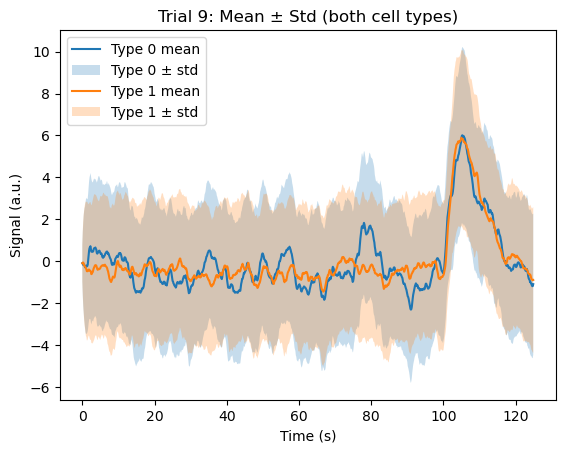

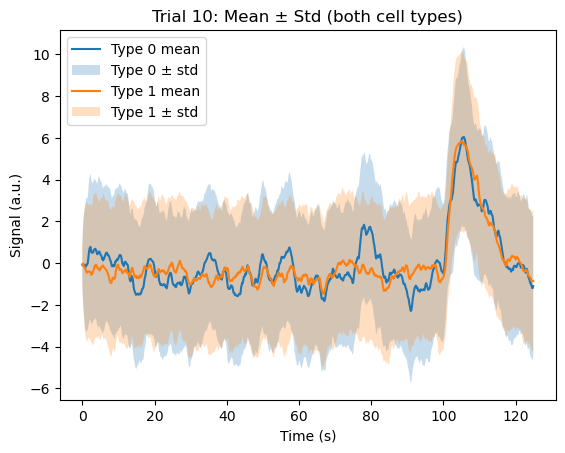

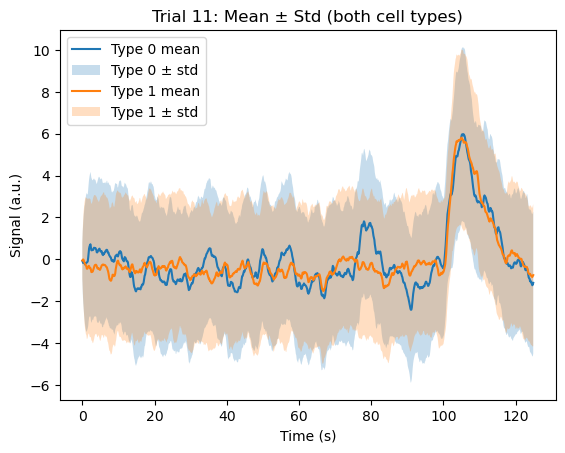

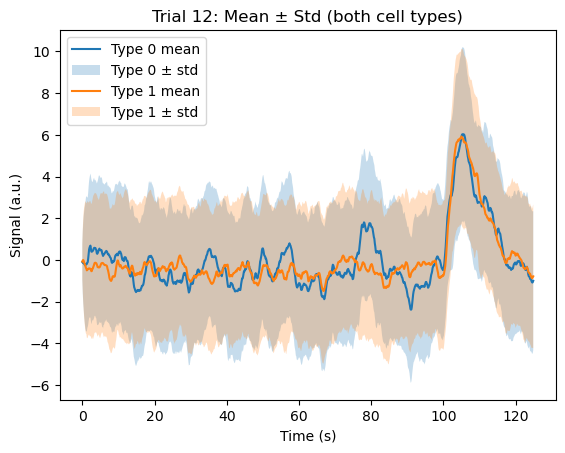

In [6]:
idx0 = np.where(labels == 0)[0]
idx1 = np.where(labels == 1)[0]
T    = traces.shape[-1]
time_sec = np.arange(T) * cfg.dt

for l in range(cfg.n_trials):
    tr0 = traces[idx0, l, :]  # (n0, T)
    tr1 = traces[idx1, l, :]  # (n1, T)

    mean0, std0 = tr0.mean(axis=0), tr0.std(axis=0)
    mean1, std1 = tr1.mean(axis=0), tr1.std(axis=0)

    plt.figure()
    plt.plot(time_sec, mean0, label="Type 0 mean")
    plt.fill_between(time_sec, mean0-std0, mean0+std0, alpha=0.25, label="Type 0 ± std")

    plt.plot(time_sec, mean1, label="Type 1 mean")
    plt.fill_between(time_sec, mean1-std1, mean1+std1, alpha=0.25, label="Type 1 ± std")

    plt.title(f"Trial {l+1}: Mean ± Std (both cell types)")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal (a.u.)")
    plt.legend()
    plt.show()

In [7]:
save_path = "./"
np.savez_compressed(
    save_path,
    traces=traces.astype(np.float32),
    xyz=positions.astype(np.float32),
    labels=labels.astype(np.int64)
)
print("Saved ->", save_path)

Saved -> /Users/dongbaiqi/Desktop/Tang Lab/Spatially_aware_dimensionality_reduction/PythonProject/data/simulated_spatial_neural_data_harder.npz


In [8]:
print(traces.shape)

(1000, 12, 1000)


In [9]:
print(positions.shape)

(1000, 2)


In [10]:
print(labels.shape)

(1000,)
